# Searching Unstructured and Structured Data #
## Assignment 1: Retrieval models [100 points] ##
**TA**: Nikos Voskarides (n.voskarides@uva.nl)

In this assignment you will get familiar with basic information retrieval concepts. You will implement and evaluate different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Monday, 22/1, at 23:59**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](https://piazza.com/class/ixoz63p156g1ts).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [1]:
import collections
import copy
import gensim
import gensim.models.keyedvectors as word2vec
import glob
import io
import logging
import numpy as np
import os
import pandas as pd
import pyndri
import pyndri.compat
import re
import sys
import time
import matplotlib

from gensim.similarities import WmdSimilarity
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from itertools import groupby


plt.style.use('ggplot')

In [2]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """
    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)



Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.

    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [3]:
import pyndri
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [4]:
print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [5]:
example_document = index.document(index.document_base())
#print(example_document)


Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [6]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]


In [7]:
print(list(token2id.items())[:15])

[('beating', 4098), ('contendes', 62800), ('efstratios', 82269), ('benois', 37919), ('polygamous', 188861), ('soreness', 224705), ('ripston', 204475), ('guarjila', 106541), ('fisabillilah', 92938), ('masu', 153369), ('dura', 80381), ('drosma', 79358), ('chaij', 53907), ('weekend', 662), ('cardamoms', 51052)]


In [8]:
a = pyndri.extract_dictionary(index)

In [9]:
#example_document[1]

Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [10]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [11]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [12]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [13]:
import collections
import io
import logging
import sys
import re

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                break

    return topics
#
#with open('./ap_88_89/topics_title', 'r') as f_topics:
    #print(parse_topics([f_topics]))

### Task 1: Implement and compare lexical IR methods [40 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html). **[5 points]**
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[10 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[10 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand how the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [14]:
import time

start_time=time.time() 

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Gathering statistics about 456 terms.
Inverted index creation took 28.673476696014404 seconds.


In [15]:
len(inverted_index) #inverted index is only for queries

456

In [16]:
#query_term_ids #are the ids of the words inside the queries

In [46]:
from collections import defaultdict

    

def run_retrieval(model_name, score_fn, **args):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    
    retrieval_start_time = time.time()
    
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    print('Retrieving using', model_name)


    data = {}
    
    for qid in tokenized_queries.keys(): #for each query

        try:
            if score_fn==bm25:
                tokenized_queries[qid] = list(set(tokenized_queries[qid]))
        except:
            pass
        
        score = defaultdict(float)

        query_length = len(tokenized_queries[qid])
        for query_term_id in tokenized_queries[qid]: #for each word_id in query


            for (int_document_id,document_term_freq) in zip(list(inverted_index[query_term_id].keys())
                                                            ,list(inverted_index[query_term_id].values())):
                #for each document where the word appears, calculate scoring function increment its score
                
                try:
                    if score_fn == dirichlet_prior or score_fn == absolute_discounting:
                        new_score = score_fn(int_document_id, query_term_id, document_term_freq,query_length, **args)
                    else:
                        new_score = score_fn(int_document_id, query_term_id, document_term_freq, **args)            

                except:
                    new_score = score_fn(int_document_id, query_term_id, document_term_freq, **args)            
                
                score[int_document_id] += new_score 
                



        #turn dict to list of tuples and continue        
        # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
        data[qid] = [(score, index.ext_document_id(doc_id)) for (score, doc_id) in zip(score.values(), score.keys())]
        
# write out  
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)
    

### TF-IDF

In [18]:
def tfidf(int_document_id, query_term_id, document_term_freq):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
    
    ## Amount of time a term appears in a document  
    df = document_term_freq
   
    ## Number of documents containing the query word
    n = len(inverted_index[query_term_id])
    

    tf = np.log2(1 + df)

    idf = np.log2((n/df))
    
    score = tf * idf

    return score




In [19]:
import os

try:
    os.remove('./retrievals/tf-idf.run')
except Exception:
    pass

start_time=time.time() 
run_retrieval('./retrievals/tf-idf',tfidf)
print('TF-IDF scoring took', time.time() - start_time, 'seconds.')

Retrieving using ./retrievals/tf-idf
TF-IDF scoring took 23.58068537712097 seconds.


In [20]:
!trec_eval -m all_trec  ./ap_88_89/qrel_validation ./retrievals/tf-idf.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.3200
recall_1000           	all	0.5766
ndcg_cut_10           	all	0.3409
map_cut_1000          	all	0.2049


In [21]:
!trec_eval -m all_trec  ./ap_88_89/qrel_test ./retrievals/tf-idf.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.3700
recall_1000           	all	0.5352
ndcg_cut_10           	all	0.3549
map_cut_1000          	all	0.1592


### BM25

In [22]:
def bm25(int_document_id, query_term_id, document_term_freq ,k1=1.2 , b=0.75,length_avg = np.mean(np.array(list(document_lengths.values())))) :
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    
    Hyperparameters: k1=1.2 and b=0.75
    -
    """
    
    ## Amount of time a term appears in a document  
    df = document_term_freq
     
    
    ## tf, idf
    tf = np.log2(1 + df)
    idf = np.log2((len(inverted_index[query_term_id])/df))
    
    ## Total terms in a document : document_lengths[int_document_id]    
    ## Amount of documents containing a term : len(inverted_index[query_term_id])
    ## document length : document_lengths[int_document_id]
    
    return ((k1+1)*tf*idf)/(k1*((1-b)+b*(document_lengths[int_document_id] /length_avg))+tf)


In [23]:
try:
    os.remove('./retrievals/bm25.run')
except Exception:
    pass
    


start_time=time.time() 

run_retrieval('./retrievals/bm25',bm25)

print('BM25 scoring took', time.time() - start_time, 'seconds.')

Retrieving using ./retrievals/bm25
BM25 scoring took 26.619696378707886 seconds.


In [24]:
##trec_eval command for evalutaion of bm25 for validation set

!trec_eval -m all_trec ./ap_88_89/qrel_validation ./retrievals/bm25.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.2333
recall_1000           	all	0.5075
ndcg_cut_10           	all	0.2360
map_cut_1000          	all	0.1397


In [25]:
##trec_eval command for evalutaion of bm25 for test set

!trec_eval -m all_trec ./ap_88_89/qrel_test ./retrievals/bm25.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.2417
recall_1000           	all	0.4779
ndcg_cut_10           	all	0.2392
map_cut_1000          	all	0.1115


### Jelinek-Mercer

In [26]:
#precompute the 2nd term of jelinek mercer smoothening to speed-up computations
P_mle_col = dict()
for query_term_id in query_term_ids:
    
    P_mle_col[query_term_id] = ((index.get_term_frequencies()[query_term_id]) )/index.total_terms()

In [27]:
def jelinek_mercer(int_document_id, query_term_id, document_term_freq, lambd = 0.8):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term
    :param lambd: lambda value of linear interpolation (default = 0.75)
    """


    return np.log((1+(1-lambd)/lambd+document_term_freq/(document_lengths[int_document_id]*P_mle_col[query_term_id])))
    

In [28]:
try:
    os.remove('./retrievals/jelinek_mercer.run')
except Exception:
    pass

start_time = time.time()
test_dict = run_retrieval('./retrievals/jelinek_mercer',jelinek_mercer)
print ('elapsed time:',time.time()-start_time)

Retrieving using ./retrievals/jelinek_mercer
elapsed time: 19.628849983215332


In [29]:
#trec_eval command for evalutaion of jelinek_mercer for validation set

!trec_eval -m all_trec  ./ap_88_89/qrel_validation ./retrievals/jelinek_mercer.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.3800
recall_1000           	all	0.6224
ndcg_cut_10           	all	0.3801
map_cut_1000          	all	0.2248


In [30]:
#trec_eval command for evalutaion of jelinek_mercer for test set

!trec_eval -m all_trec  ./ap_88_89/qrel_test ./retrievals/jelinek_mercer.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.3750
recall_1000           	all	0.6264
ndcg_cut_10           	all	0.3870
map_cut_1000          	all	0.1980


### Dirichlet Prior

In [31]:
#pre-compute p(w|C) term ---- uncomment if you want to compute with different p(w|C)


# P_mle_col = dict()
# for query_term_id in query_term_ids:
#     count = 0 
#     for int_document_id in inverted_index[query_term_id].keys():
        
#         count +=(inverted_index[query_term_id][int_document_id]/document_lengths[int_document_id])
    
    
#     P_mle_col[query_term_id] = count*(1/index.total_terms())

In [32]:
def dirichlet_prior(int_document_id, query_term_id, document_term_freq,query_length, mu=1400):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """
   
    ##p_w_C --------------> P_mle_col[query_term_id]
    ## document length --------------> document_lengths[int_document_id]
    #l --------------> document_lengths[int_document_id]
    
   
    return np.log(1+(document_term_freq/(mu*P_mle_col[query_term_id])))\
                                    +query_length*np.log(mu/(mu+document_lengths[int_document_id]))
                                                    

In [33]:
#final run
try:
    os.remove('./retrievals/dirichlet_prior.run')
except Exception:
    pass


start_time = time.time()
test_dict = run_retrieval('./retrievals/dirichlet_prior',dirichlet_prior, mu = 1400)
print ('elapsed time:',time.time()-start_time)

Retrieving using ./retrievals/dirichlet_prior
elapsed time: 21.19205331802368


In [34]:
#trec_eval command for evalutaion of dirichlet_prior - validation set

!trec_eval -m all_trec  ./ap_88_89/qrel_validation ./retrievals/dirichlet_prior.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.3933
recall_1000           	all	0.6097
ndcg_cut_10           	all	0.4190
map_cut_1000          	all	0.2289


In [35]:
#trec_eval command for evalutaion of dirichlet_prior - test set

!trec_eval -m all_trec   ./ap_88_89/qrel_test ./retrievals/dirichlet_prior.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.3817
recall_1000           	all	0.6038
ndcg_cut_10           	all	0.3732
map_cut_1000          	all	0.1977


### Absolute discounting

In [36]:
def absolute_discounting(int_document_id, query_term_id, document_term_freq,query_length, delta=0.9):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param document_term_freq: the document term frequency of the query term 
    """

    ## p_w_C = P_mle_col[query_term_id])
    ## document length : document_lengths[int_document_id]
    ## document length u: collection_frequencies[query_term_id]
    
    
 
    
    return np.log(np.max(document_term_freq-delta,0)/ \
                (delta*unique_terms_per_document[int_document_id]*P_mle_col[query_term_id]))\
                +query_length*np.log((delta*unique_terms_per_document[int_document_id])/delta)
    


In [37]:
#final run
try:
    os.remove('./retrievals/absolute_discounting.run')
except Exception:
    pass



start_time = time.time()
test_dict = run_retrieval('./retrievals/absolute_discounting',absolute_discounting)
print ('elapsed time:',time.time()-start_time)

Retrieving using ./retrievals/absolute_discounting
elapsed time: 41.91452074050903


In [38]:
#trec_eval command for evalutaion of Absolute Discounting - validation set

!trec_eval -m all_trec  ./ap_88_89/qrel_validation ./retrievals/absolute_discounting.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.3200
recall_1000           	all	0.5739
ndcg_cut_10           	all	0.3341
map_cut_1000          	all	0.2007


In [39]:
#trec_eval command for evalutaion of Absolute Discounting - test set

!trec_eval -m all_trec  ./ap_88_89/qrel_test ./retrievals/absolute_discounting.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.3500
recall_1000           	all	0.5811
ndcg_cut_10           	all	0.3514
map_cut_1000          	all	0.1656


### Selection of the Hyperparameters based on validation set

In [40]:
import glob
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [41]:
def get_scores(filenames, validation=True):
    """
    Function to get scores from trec_eval using a 
    :param filenames: a list of *.run files (retrieval scores for queries)
    :param validation: boolean. Perform evaluation on validation or test set (queries)
    """
    scores = {}
    for filename in filenames:
        param_value = float(filename.split("=")[-1].split('.run')[0])
        if validation:
            result = !trec_eval -m all_trec ./ap_88_89/qrel_validation {filename} | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"
        else:
            result = !trec_eval -m all_trec ./ap_88_89/qrel_test {filename} | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

        for row in result:
            metric = row.split(' ')[0]
            score = float(row.split('\t')[-1])
            if metric not in scores.keys():
                scores[metric] = {}
            scores[metric][param_value] = score
    return scores

In [42]:
def test_hyperparameters(hyperparameters,funct_name,score_function):
    
    for param_value in hyperparameters:
        
        start_time = time.time()
        
        filename = 'retrievals/'+funct_name+'='+str(param_value)
        
        if funct_name== 'jelinek_mercer_lambda':
            run_retrieval(filename,score_function, lambd = param_value)
        elif funct_name=='dirichlet_prior_mu':
            run_retrieval(filename,dirichlet_prior, mu = param_value)
        
        elif funct_name=='absolute_discounting_delta':
            run_retrieval(filename,absolute_discounting, delta = param_value)
            
        else:
            print ("Wrong method name")
            return
            

        print ('finished {} in {} sec'.format(filename,(time.time()-start_time)))
    
    filenames = glob.glob('./retrievals/'+funct_name+'=*')
    scores = get_scores(filenames)
    scores = pd.DataFrame.from_dict(scores,dtype=float)
    scores.index.name = 'delta'
    
    return scores

In [44]:
def visualize(df):
    df.drop('recall_1000',axis=1).plot()

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]

finished retrievals/jelinek_mercer_lambda=0.1 in 0.000148773193359375 sec
finished retrievals/jelinek_mercer_lambda=0.2 in 2.6941299438476562e-05 sec
finished retrievals/jelinek_mercer_lambda=0.3 in 9.34600830078125e-05 sec
finished retrievals/jelinek_mercer_lambda=0.4 in 7.414817810058594e-05 sec
finished retrievals/jelinek_mercer_lambda=0.5 in 7.367134094238281e-05 sec
Retrieving using retrievals/jelinek_mercer_lambda=0.6
finished retrievals/jelinek_mercer_lambda=0.6 in 17.84770703315735 sec
finished retrievals/jelinek_mercer_lambda=0.7 in 0.00012826919555664062 sec
finished retrievals/jelinek_mercer_lambda=0.8 in 7.62939453125e-06 sec
finished retrievals/jelinek_mercer_lambda=0.9 in 1.811981201171875e-05 sec


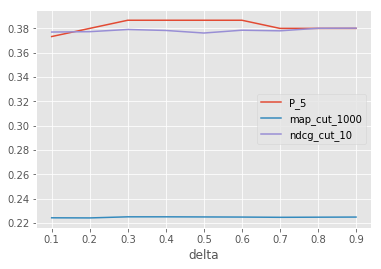

In [54]:
#Hyperparameter selection for Jelinek Mercer by choosing the right lambda hyperparameter

df_jelinek = test_hyperparameters([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],'jelinek_mercer_lambda',jelinek_mercer)

visualize(df_jelinek)

In [51]:
import pandas as pd

##-----> Save dataframe-uncomment for saving

#df_jelinek.to_csv('./dataframes/jelinek', sep='\t')


##-----> Load dataframe-uncomment for saving

#df_jelinek = pd.read_csv('./dataframes/jelinek',sep='\t')

Text(0,0.5,'trec_eval_score  all')

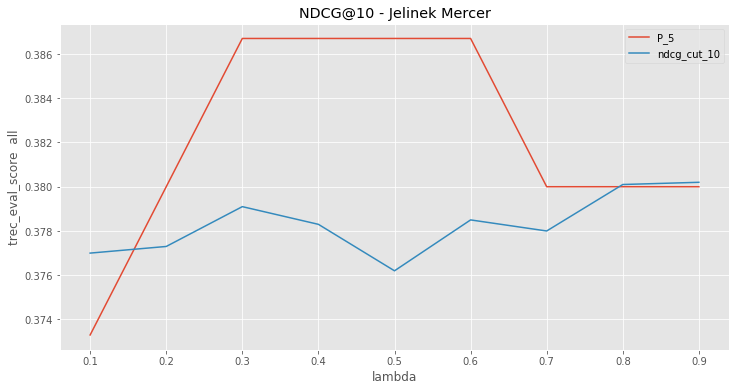

In [55]:

a = df_jelinek.drop(['recall_1000','map_cut_1000'],axis=1).plot(title='NDCG@10 - Jelinek Mercer', figsize=(12,6))
a.set_xlabel("lambda")
a.set_ylabel("trec_eval_score  all")

In [56]:
fig = a.get_figure()

fig.savefig('./figures/j_m.png')

Retrieving using retrievals/dirichlet_prior_mu=500
finished retrievals/dirichlet_prior_mu=500 in 35.208718061447144 sec
Retrieving using retrievals/dirichlet_prior_mu=600
finished retrievals/dirichlet_prior_mu=600 in 34.75053930282593 sec
Retrieving using retrievals/dirichlet_prior_mu=700
finished retrievals/dirichlet_prior_mu=700 in 34.69778609275818 sec
Retrieving using retrievals/dirichlet_prior_mu=800
finished retrievals/dirichlet_prior_mu=800 in 35.60779523849487 sec
Retrieving using retrievals/dirichlet_prior_mu=900
finished retrievals/dirichlet_prior_mu=900 in 36.09760570526123 sec
Retrieving using retrievals/dirichlet_prior_mu=1000
finished retrievals/dirichlet_prior_mu=1000 in 35.977718114852905 sec
Retrieving using retrievals/dirichlet_prior_mu=1100
finished retrievals/dirichlet_prior_mu=1100 in 36.00215148925781 sec
Retrieving using retrievals/dirichlet_prior_mu=1200
finished retrievals/dirichlet_prior_mu=1200 in 35.71282076835632 sec
Retrieving using retrievals/dirichlet_pr

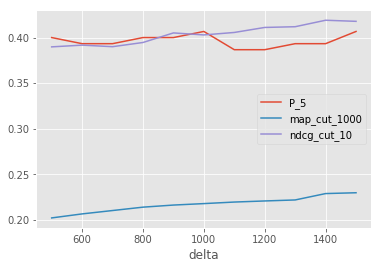

In [57]:
#Hyperparameter selection for Dirichlet Prior by choosing the right lambda hyperparameter

df_dirichlet = test_hyperparameters(np.arange(500,1501, 100),'dirichlet_prior_mu',dirichlet_prior)

visualize(df_dirichlet )   

In [58]:
##-----> Save dataframe-uncomment for saving

#df_dirichlet.to_csv('./dataframes/dirichlet', sep='\t')


##-----> Load dataframe-uncomment for saving

#df_dirichlet = pd.read_csv('./dataframes/dirichlet',sep='\t')


Text(0,0.5,'trec_eval_score all')

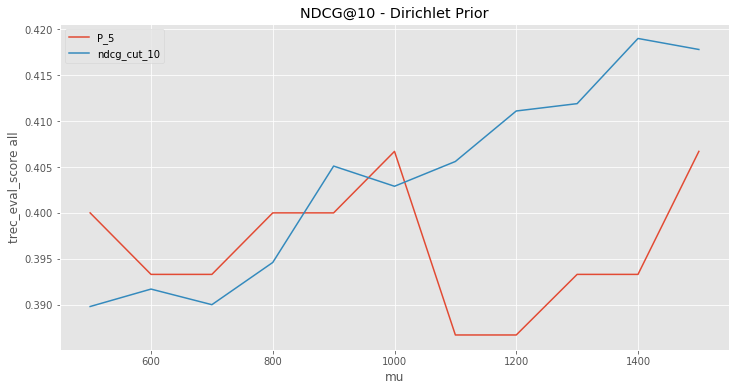

In [59]:
a2 = df_dirichlet.drop(['recall_1000','map_cut_1000'],axis=1).plot(title='NDCG@10 - Dirichlet Prior', figsize=(12,6))
a2.set_xlabel("mu")
a2.set_ylabel("trec_eval_score all")

In [60]:
fig = a2.get_figure()

fig.savefig('./figures/d_p.png')

Retrieving using retrievals/absolute_discounting_delta=0.1
finished retrievals/absolute_discounting_delta=0.1 in 44.948633670806885 sec
Retrieving using retrievals/absolute_discounting_delta=0.2
finished retrievals/absolute_discounting_delta=0.2 in 44.844966888427734 sec
Retrieving using retrievals/absolute_discounting_delta=0.3
finished retrievals/absolute_discounting_delta=0.3 in 44.21062111854553 sec
Retrieving using retrievals/absolute_discounting_delta=0.4
finished retrievals/absolute_discounting_delta=0.4 in 45.91748881340027 sec
Retrieving using retrievals/absolute_discounting_delta=0.5
finished retrievals/absolute_discounting_delta=0.5 in 43.314305543899536 sec
Retrieving using retrievals/absolute_discounting_delta=0.6
finished retrievals/absolute_discounting_delta=0.6 in 43.256648540496826 sec
Retrieving using retrievals/absolute_discounting_delta=0.7
finished retrievals/absolute_discounting_delta=0.7 in 42.54814338684082 sec
Retrieving using retrievals/absolute_discounting_de

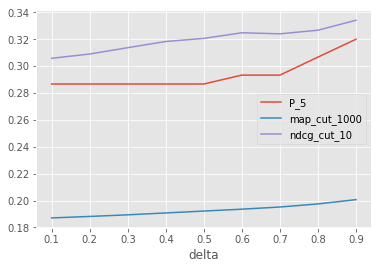

In [61]:
#Hyperparameter selection for Absolute Discounting by choosing the right lambda hyperparameter

df_absolute = test_hyperparameters([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],'absolute_discounting_delta',absolute_discounting)

visualize(df_absolute )   

In [62]:
##-----> Save dataframe-uncomment for saving

#df_absolute.to_csv('./dataframes/absolute', sep='\t')


##-----> Load dataframe-uncomment for saving

#df_absolute = pd.read_csv('./dataframes/absolute',sep='\t')

Text(0,0.5,'trec_eval_score  all')

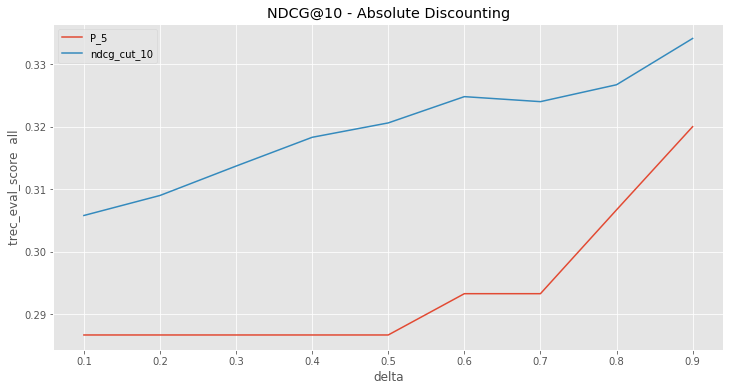

In [63]:
a3 = df_absolute.drop(['recall_1000','map_cut_1000'],axis=1).plot(title='NDCG@10 - Absolute Discounting', figsize=(12,6))
a3.set_xlabel("delta")
a3.set_ylabel("trec_eval_score  all")

In [64]:
fig = a3.get_figure()

fig.savefig('./figures/a_d.png')

### Query scores - Evaluation measures on test set

In [65]:
import re
import pandas as pd

def parse_retrieval_scores(file_name, regexp = "^ndcg_cut_10\s" ,validation=True):
    """Return a pd.Series of the given score (defined in regexp) for validation or test set.
    regexp defines the lines (corresponding to different metrics) to be retrieved.
    
    >>> parse_retrieval_scores('bm25.run', "^ndcg_cut_10\s", validation = False)
    Returns dataframe for NDCG@10 scores for the BM25 retrieval in the test set
    """

    df = pd.Series()
    regexp ="\'"+regexp+"\'"
    series = pd.Series()
    if validation:
        qrel_file = 'qrel_validation'
    else: 
        qrel_file = 'qrel_test'
    
    results = !trec_eval -m all_trec -q ./ap_88_89/{qrel_file} {file_name} | grep -E {regexp}
    print('Retrieving',len(results), 'results')
    for result in results:
        result = re.sub( '\s+', ' ', result ).strip().split()

        idx = result[1]
        value = float(result[2])

        series.set_value(idx,value)
    return series.drop('all')

In [66]:
best_hyperparameters = ['tf-idf.run','bm25.run','jelinek_mercer_lambda=0.8.run',
                        'dirichlet_prior_mu=1400.run','absolute_discounting_delta=0.9.run']
names = ['tf-idf','bm25','jelinek_mercer','dirichlet_prior','absolute_discounting']
list_of_series ={}

#creates a dataframe with ndcg@10 score of all the queries inside the test set
for m, name in zip(best_hyperparameters,names):
    list_of_series[name]=parse_retrieval_scores('./retrievals/'+m, "^ndcg_cut_10\s", validation = False)
    

best_scores = pd.DataFrame(list_of_series,columns=names)
best_scores.head()

Retrieving 121 results
Retrieving 121 results
Retrieving 121 results
Retrieving 121 results
Retrieving 121 results


,tf-idf,bm25,jelinek_mercer,dirichlet_prior,absolute_discounting
100,0.6602,0.3102,0.2980,0.3539,0.2489
101,0.1584,0.3843,0.4734,0.5869,0.0694
102,0.0000,0.2369,0.4378,0.5072,0.0000
104,0.1299,0.5501,0.2579,0.0784,0.3566
105,0.0000,0.0000,0.0000,0.0000,0.0000


Text(0,0.5,'ndsg@10')

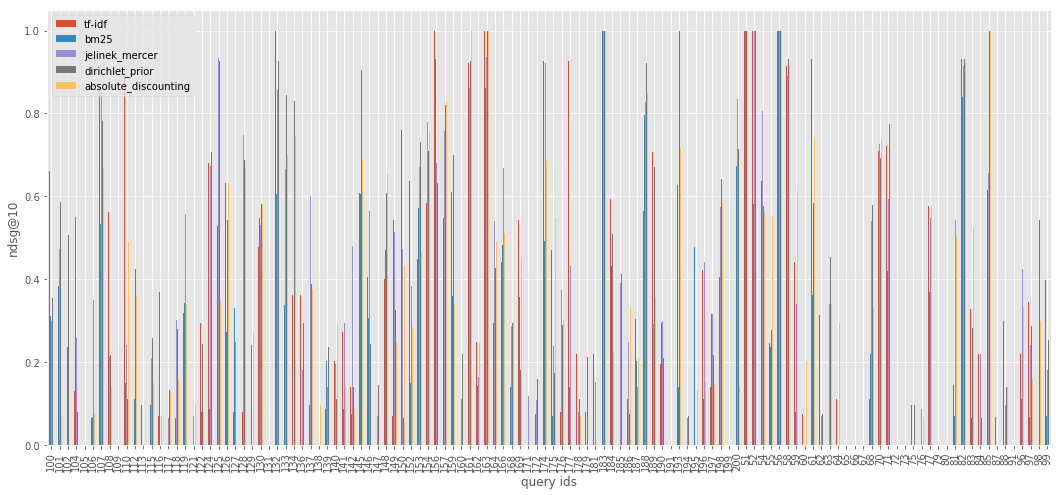

In [67]:
#plot the queries ndcg@10 scores contained inside the test set - all
p = best_scores.plot(kind='bar',figsize=(18,8))
p.set_xlabel("query ids")
p.set_ylabel("ndsg@10")


Text(0,0.5,'ndsg@10')

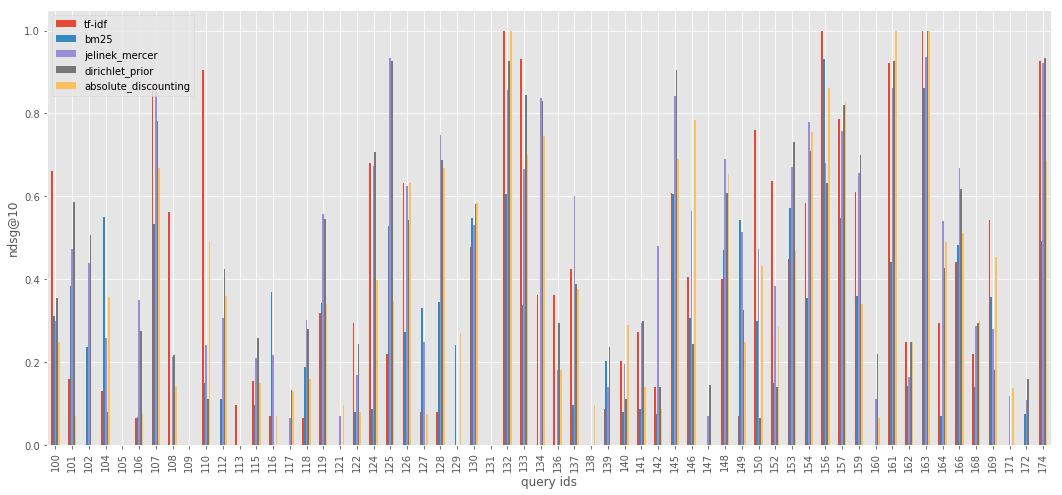

In [68]:
#plot the queries ndcg@10 scores contained inside the test set -first split
p2 = best_scores[:60].plot(kind='bar',figsize=(18,8))
p2.set_xlabel("query ids")
p2.set_ylabel("ndsg@10")


Text(0,0.5,'ndsg@10')

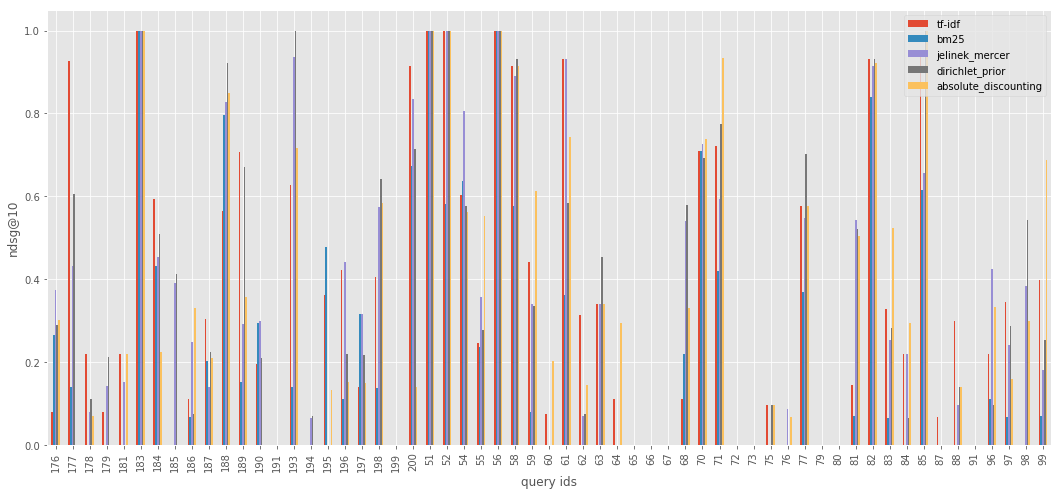

In [69]:
#plot the queries ndcg@10 scores contained inside the test set - second split
p3=best_scores[61:].plot(kind='bar',figsize=(18,8))
p3.set_xlabel("query ids")
p3.set_ylabel("ndsg@10")


In [70]:
print('110',queries['110'],"- tf-idf")
print('100',queries['100'],"- tf-idf")
print('177',queries['177'],"- tf-idf")
print('102',queries['102'],"- probabilistic")


110 Black Resistance Against the South African Government - tf-idf
100 Controlling the Transfer of High Technology - tf-idf
177 English as the Official Language in U.S. - tf-idf
102 Laser Research Applicable to the U.S.'s Strategic Defense Initiative - probabilistic


Text(0,0.5,'ndcg@10')

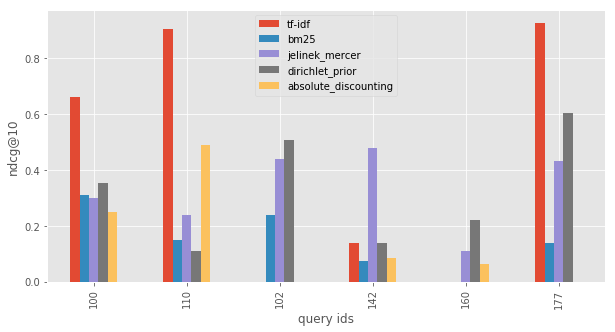

In [71]:
# Plot the queries we have chosen for our analysis inside the report
p3=best_scores.loc[['100','110','102','142','160','177']].plot(kind='bar',figsize=(10,5))
p3.set_xlabel("query ids")
p3.set_ylabel("ndcg@10")


In [72]:
fig = p3.get_figure()

fig.savefig('./figures/queries_sp.png')

### Perform statistical-testing

In [73]:
from scipy.stats import ttest_rel
from itertools import combinations

In [74]:
def t_test(method1,method2,a=0.05):
    
    p_value = ttest_rel(method1, method2)[1]
    
    if p_value>a:
        return (p_value, 'not-rejected')
    else:
        return (p_value, 'rejected')

In [75]:
#perform pairwise t-test
combs = list(combinations(best_scores.columns,2))

for pair in combs:
    print(pair[0],pair[1])
    print(t_test(best_scores[pair[0]],best_scores[pair[1]],a=0.05/len(combs)))
    print('\n')

tf-idf bm25
(3.9433421321260045e-07, 'rejected')


tf-idf jelinek_mercer
(0.11253263307694794, 'not-rejected')


tf-idf dirichlet_prior
(0.386690453382582, 'not-rejected')


tf-idf absolute_discounting
(0.854379625667795, 'not-rejected')


bm25 jelinek_mercer
(3.685866641820747e-13, 'rejected')


bm25 dirichlet_prior
(2.042253913433874e-09, 'rejected')


bm25 absolute_discounting
(2.0236768146890488e-07, 'rejected')


jelinek_mercer dirichlet_prior
(0.22491057447469956, 'not-rejected')


jelinek_mercer absolute_discounting
(0.038003470500979526, 'not-rejected')


dirichlet_prior absolute_discounting
(0.24363103206749817, 'not-rejected')




### Task 2: Latent Semantic Models (LSMs) [20 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

Perform analysis **[5 points]**

In [76]:
import copy
import gensim
import logging
import pyndri
import pyndri.compat
import sys
from itertools import groupby

In [77]:
# Connector class pyndri - gensim - implemented by us
class IndriTermDocFreq(gensim.interfaces.CorpusABC):
    """Integrates an Index with Gensim's word2vec implementation."""

    def __init__(self, index, dictionary, list_docs = None, max_documents=None):
        assert isinstance(index, pyndri.Index)

        self.index = index
        self.dictionary = dictionary
        self.list_docs = list_docs
        self.max_documents = max_documents

    def _maximum_document(self):
        if self.max_documents is None:
            return self.index.maximum_document()
        else:
            return min(
                self.max_documents + self.index.document_base(),
                self.index.maximum_document())

    def __iter__(self):
        
        if self.list_docs:
            rng = self.list_docs
        else:
            rng = range(self.index.document_base(), self._maximum_document())
        
        for int_doc_id in rng:
            _, tokens = self.index.document(int_doc_id)
            
            yield [(key,len(list(group)) ) for  key, group in groupby(sorted(list(tokens))) if key>0]

    def __len__(self):
        return self._maximum_document() - self.index.document_base()
    

In [78]:
def transform_queries(queries, model):
    """
    Given the ordered dict queries and an lsi model, transform the queries to the latent space
    """
    transformed_queries = {}
    for q_id in queries:
#         print(tokenized_queries[q_id])
#         print([(key,len(list(group)) ) for  key, group in groupby(tokenized_queries[q_id]) if key>0])
        transformed_queries[q_id] = model[[(key,len(list(group)) ) for  key, group in groupby(tokenized_queries[q_id]) if key>0]]
    return transformed_queries

### Parses the ranking tf-idf.run file and creates gensim index for each query

In [79]:
#create inverse mapping, because pyndri sucks
extDocId2id={}
for id in range(index.document_base(), index.maximum_document()):
    extDocId2id[index.ext_document_id(id)] = id

In [80]:
tfidf_rank = defaultdict(list)

with open('./retrievals/tf-idf.run', 'r') as file:
    for line in file.readlines():
        q_id = line.split()[0]
        doc_id = line.split()[2]
        tfidf_rank[q_id].append(extDocId2id[doc_id])

In [81]:
def gensim_rank(model, tfidf_rank, transformed_queries):
    """
    Generates new ranking for each query, based on 1000 top TF-IDF results
    """
    start_time = time.time()
    ranking_new = {}
    for q_id in queries.keys():
    # for q_id in ['100','101']:
        top1000 = tfidf_rank[q_id]
        gimme_docs = IndriTermDocFreq(index,dictionary,list_docs=top1000)
        gensim_index = gensim.similarities.MatrixSimilarity(model[gimme_docs], num_features = model.num_topics)

        sims = gensim_index[transformed_queries[q_id]]
        ranking_new[q_id] = tuple(zip(sims,map(lambda x: index.ext_document_id(x), top1000)))

    print("took %i sec for %i latent dims"%(time.time() - start_time ,model.num_topics))
    return ranking_new

In [82]:
def save_retrieval(model_name,ranking_dict):
    run_out_path = 'retrievals/'+model_name
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=ranking_dict,
            out_f=f_out,
            max_objects_per_query=1000)

** function to score individual query-document <u>(used for L2R)</u> **

In [83]:
def gensim_rank_pair(doc_id,q_id, model, transformed_queries):
    """
    Generates new ranking for each doc-id () query pair, for the given model (LSI or LDA)
    """
    lda_vec1 = model[IndriTermDocFreq(index,dictionary,list_docs=[doc_id])]
    lda_vec2 = transformed_queries[q_id]
    return gensim.matutils.cossim(list(lda_vec1)[0],lda_vec2)

In [84]:
def evaluation_results(model_name):
    print(model_name)
    r_fname = 'retrievals/'+model_name
    print("Validation")
    !trec_eval -m all_trec ./ap_88_89/qrel_validation {r_fname} | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"
    print("Test")
    !trec_eval -m all_trec ./ap_88_89/qrel_test {r_fname} | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

### LSI ( Latent Semantic Analysis)

In [85]:
#initiate lsi model
lsi = gensim.models.LsiModel(id2word=id2token)

In [86]:
#create LSI for different # dimensions (if not in disk)

# generator for passing counts of documents from pyndri to gensim
wordfreq = IndriTermDocFreq(index,dictionary)

for n_top in [10,50,100, 150,200, 250,300,400, 500]:
    fname = 'lsi/lsi_counts%i.mod'%n_top

    if os.path.exists(fname)==False:
        start_time = time.time()
        lsi = gensim.models.LsiModel(corpus = wordfreq,
                                     id2word=id2token,
                                     num_topics=n_top)
        print('lsi with %i topics took %s sec'%(n_top,time.time()-start_time))
        print(fname)
        lsi.save(fname)

Lowest singular value for 10: 557.009890
Lowest singular value for 50: 353.227078
Lowest singular value for 100: 244.831125
Lowest singular value for 150: 209.234001
Lowest singular value for 200: 181.981725
Lowest singular value for 250: 162.523119
Lowest singular value for 300: 150.804663
Lowest singular value for 400: 134.851795
Lowest singular value for 500: 123.256746


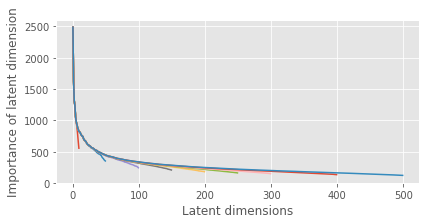

In [89]:
matplotlib.rcParams['figure.figsize'] = (6.5, 3.0)
# does not load model
#print eigenvalues
for n_top in [10,50,100,150,200,250,300,400, 500]:
    fname = 'lsi/lsi_counts%i.mod'%n_top
#     print(fname)
    lsi = lsi.load(fname,mmap='r')
    print("Lowest singular value for %i: %f"%(n_top,lsi.projection.s[-1]))
    plt.plot(lsi.projection.s,label='%i latent dims'%n_top)
plt.xlabel('Latent dimensions')
plt.ylabel('Importance of latent dimension')
# plt.title('Exploring different number of "topics" in LSI')
plt.savefig('LsiSingValues.eps', format='eps', dpi=1000)
plt.show()

In [93]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

#select appropriate lsi file:
fname = 'lsi/lsi_counts300.mod'
lsi = gensim.models.LsiModel.load(fname)

transformed_queries = transform_queries(queries, lsi)

evaluation_results('lsi_counts300')

lsi_counts300
Validation
P_5                   	all	0.1467
recall_1000           	all	0.5766
ndcg_cut_10           	all	0.1664
map_cut_1000          	all	0.1166
Test
P_5                   	all	0.1550
recall_1000           	all	0.5352
ndcg_cut_10           	all	0.1439
map_cut_1000          	all	0.0816


### LDA (Latent Dirichlet allocation)

In [95]:
#create LDA for different # topics (if not in disk)

# generator for passing counts of documents from pyndri to gensim
wordfreq = IndriTermDocFreq(index,dictionary)

for n_top in [10,50]:
    model_name = 'lda_'+str(n_top)
    fname = 'lda/%s'%model_name

    if os.path.exists(fname)==False:
        start_time = time.time()
        lda = gensim.models.ldamulticore.LdaMulticore(corpus = wordfreq,
                                     id2word=id2token,
#                                      alpha='auto',
                                     minimum_probability=0,
                                     num_topics=n_top)
        print('lda with %i topics took %s sec'%(n_top,time.time()-start_time))
        print(fname)
        lda.save(fname)
        
    else:
        print(model_name,'already exists on disk')

lda_10 already exists on disk
lda_50 already exists on disk


In [96]:
# select / load model
model_name = 'lda_50'
model = gensim.models.ldamulticore.LdaModel.load('lda/'+model_name)
model.minimum_probability=0

In [97]:
# queries_lda = transform_queries_lda(queries, lda)

transformed_queries = transform_queries(queries, model)

### Some analysis on topics generated 

In [98]:
def get_2nd_obj(x):
    (_,sc) = x
    return sc

In [99]:
max_topic_score=pd.Series(index=transformed_queries.keys())
for q_id in transformed_queries.keys():
    max_topic_score.ix[q_id] = max(map(get_2nd_obj,transformed_queries[q_id]))

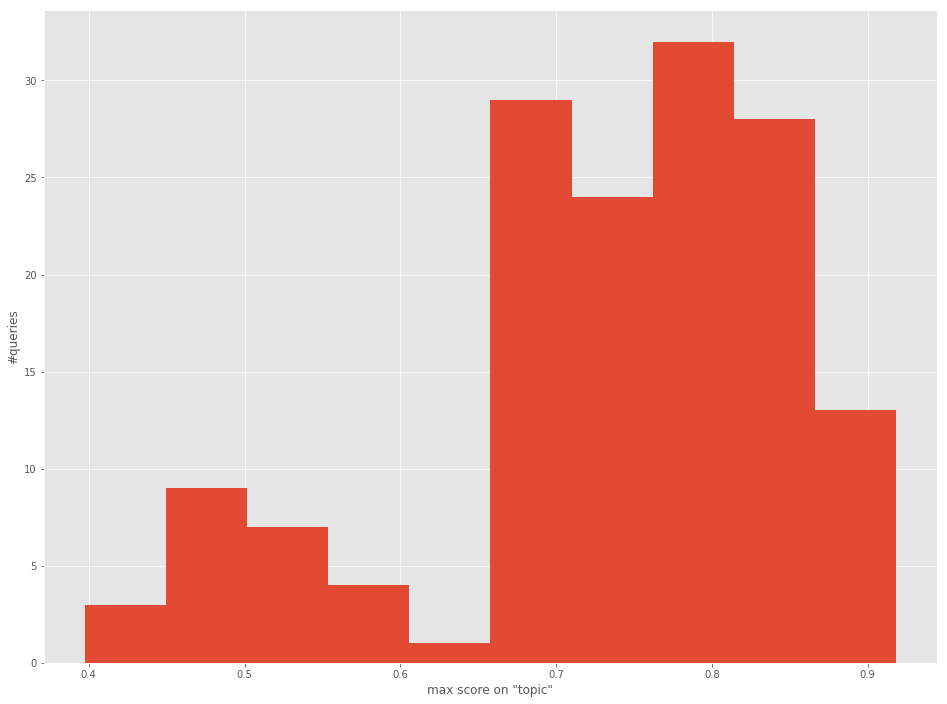

In [100]:
max_topic_score.hist()
plt.ylabel('#queries')
plt.xlabel('max score on "topic"')
plt.savefig('ldaMaxTopicScore.eps', format='eps', dpi=1000)

In [101]:
print([queries[x] for x in ['113','102','152']])

['New Space Satellite Applications', "Laser Research Applicable to the U.S.'s Strategic Defense Initiative", 'Accusations of Cheating by Contractors on U.S. Defense Projects']


In [102]:
print([queries[x] for x in ['100','177','110']])

['Controlling the Transfer of High Technology', 'English as the Official Language in U.S.', 'Black Resistance Against the South African Government']


In [103]:
print([queries[x] for x in ['142','160','110','100']])

['Impact of Government Regulated Grain Farming on International Relations', 'Vitamins - The Cure for or Cause of Human Ailments', 'Black Resistance Against the South African Government', 'Controlling the Transfer of High Technology']


In [104]:
print('less strongly correlated queries with a particular "topic" (LDA):')
print([queries[x] for x in max_topic_score.sort_values()[:3].index])

print('most strongly correlated queries with a particular "topic" (LDA):')
print([queries[x] for x in max_topic_score.sort_values(ascending=False)[:3].index])

less strongly correlated queries with a particular "topic" (LDA):
['Commercial Overfishing Creates Food Fish Deficit', 'Conflict in the Horn of Africa', 'Computer-aided Crime']
most strongly correlated queries with a particular "topic" (LDA):
['Regulation of the showing of violence and explicit sex in motion picture theaters, on television, and on video cassettes.', 'Abuse of the Elderly by Family Members, and Medical and Nonmedical Personnel, and Initiatives Being Taken to Minimize This Mistreatment', 'School Choice Voucher System and its effects upon the entire U.S. educational program']


### Scoring and ranking with gensim  

In [105]:
# check if retrieval file exists already
r_fname = 'retrievals/'+model_name
if os.path.exists(r_fname)==False:
    rr = gensim_rank(model, tfidf_rank=tfidf_rank, transformed_queries=transformed_queries)
    save_retrieval(model_name,rr)
    

In [106]:
#evaluation
evaluation_results(model_name)

lda_50
Validation
P_5                   	all	0.1467
recall_1000           	all	0.5766
ndcg_cut_10           	all	0.1478
map_cut_1000          	all	0.1136
Test
P_5                   	all	0.1217
recall_1000           	all	0.5352
ndcg_cut_10           	all	0.1296
map_cut_1000          	all	0.0800


###  Significance testing for Latent Semantic Models (LSMs)

In [107]:
#TODO remove after NB integration with other tasks
import re
def parse_retrieval_scores(file_name, regexp = "^ndcg_cut_10\s" ,validation=True):
    """Return a pd.Series of the given score (defined in regexp) for validation or test set.
    regexp defines the lines (corresponding to different metrics) to be retrieved.
    
    >>> parse_retrieval_scores('bm25.run', "^ndcg_cut_10\s", validation = False)
    Returns dataframe for NDCG@10 scores for the BM25 retrieval in the test set
    """

    df = pd.Series()
    regexp ="\'"+regexp+"\'"
    series = pd.Series()
    if validation:
        qrel_file = 'qrel_validation'
    else:
        qrel_file = 'qrel_test'
    
    results = !trec_eval -m all_trec -q ./ap_88_89/{qrel_file} {file_name} | grep -E {regexp}
    print('Retrieving',len(results), 'results')
    for result in results:
        result = re.sub( '\s+', ' ', result ).strip().split()

        idx = result[1]
        value = float(result[2])

        series.set_value(idx,value)
    return series.drop('all')

In [108]:
ndcg = pd.DataFrame()
ndcg['lda50'] = parse_retrieval_scores('retrievals/lda_50', "^ndcg_cut_10\s", validation = False)
ndcg['lsi300'] = parse_retrieval_scores('retrievals/lsi_counts300', "^ndcg_cut_10\s", validation = False)

Retrieving 121 results
Retrieving 121 results


In [109]:
from scipy.stats import ttest_rel

def t_test(method1,method2,a=0.05):
    
    p_value = ttest_rel(method1, method2)[1]
    
    if p_value>a:
        return (p_value, 'not-rejected')
    else:
        return (p_value, 'rejected')

In [110]:
ndcg.head()

,lda50,lsi300
100,0.0734,0.000
101,0.0000,0.247
102,0.0000,0.000
104,0.3301,0.000
105,0.0000,0.000


In [112]:
t_test(ndcg['lsi300'],ndcg['lda50'])

(0.5625297011030099, 'not-rejected')

### Analysis - Identify specific queries

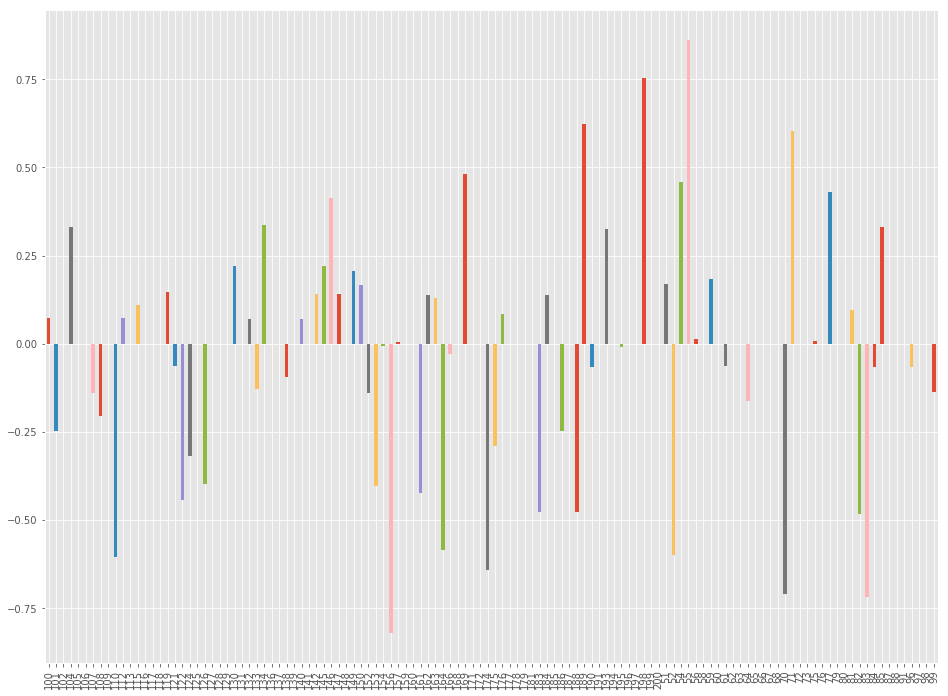

In [113]:
pd.Series(ndcg['lda50']-ndcg['lsi300']).plot(kind='bar')

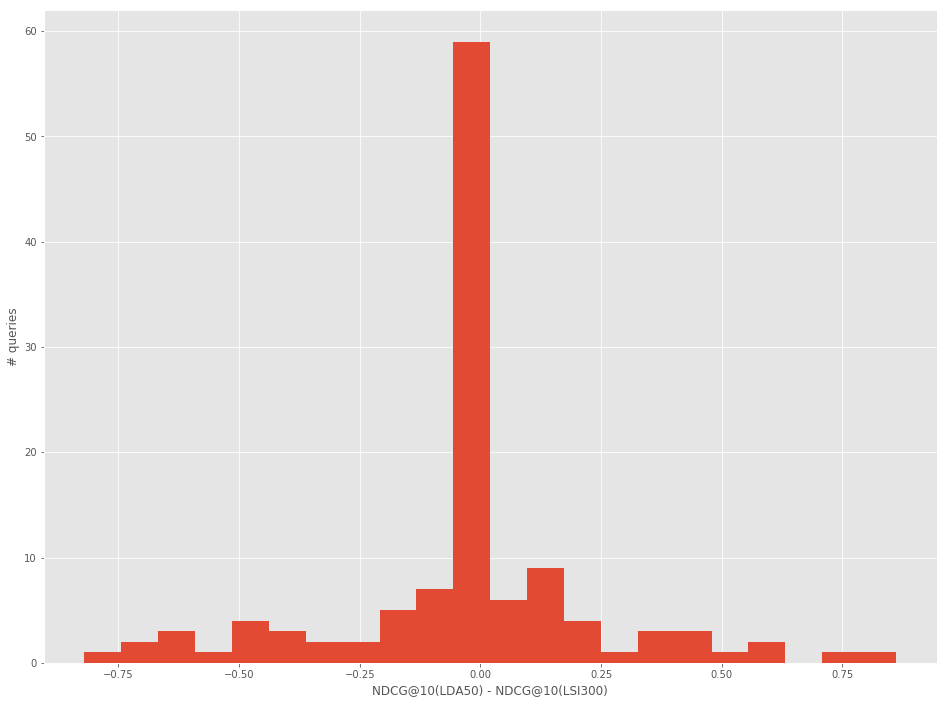

In [114]:
pd.Series(ndcg['lda50']-ndcg['lsi300']).hist(bins=22)
# plt.title("LDA(50) vs LSI(300)")
plt.xlabel("NDCG@10(LDA50) - NDCG@10(LSI300)")
plt.ylabel("# queries")
plt.savefig('ldaVSlsi.eps', format='eps', dpi=1000)

In [115]:
ldaVSlsi = pd.Series(ndcg['lda50']-ndcg['lsi300']).sort_values(ascending=False)

print('LDA outperforming LSI:\n')
for q_id, diff in zip(ldaVSlsi[:10].index,ldaVSlsi[:10].values):
    print(q_id,queries[q_id], diff)
    
print('\n\nLSI outperforming LDA:\n')
for q_id, diff in zip(ldaVSlsi[-10:].index,ldaVSlsi[-10:].values):
    print(q_id,queries[q_id], diff)

LDA outperforming LSI:

55 Insider Trading 0.8611
198 Gene Therapy and Its Benefits to Humankind 0.7538
189 Real Motives for Murder 0.6243
71 Border Incursions 0.6021
169 Cost of Garbage/Trash Removal 0.4815
54 Satellite Launch Contracts 0.4595
77 Poaching 0.42910000000000004
146 Negotiating an End to the Nicaraguan Civil War 0.4132
134 The Human Genome Project 0.3373
104 Catastrophic Health Insurance 0.3301


LSI outperforming LDA:

183 Asbestos Related Lawsuits -0.47759999999999997
188 Beachfront Erosion -0.47789999999999994
82 Genetic Engineering -0.4818
164 Generic Drugs - Illegal Activities by Manufacturers -0.5837
52 South African Sanctions -0.5984
110 Black Resistance Against the South African Government -0.6063000000000001
174 Hazardous Waste Cleanup -0.6431
70 Surrogate Motherhood -0.7105
83 Measures to Protect the Atmosphere -0.7191
156 Efforts to enact Gun Control Legislation -0.8205


### Task 3:  Word embeddings for ranking [10 points] ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).

Try one of the following (increasingly complex) methods for building query and document representations:
   * Average or sum the word vectors.
   * Cluster words in the document using [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and use the centroid of the most important cluster. Experiment with different values of K for k-means.
   * Using the [bag-of-word-embeddings representation](https://ciir-publications.cs.umass.edu/pub/web/getpdf.php?id=1248).
   
Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [267]:
## Create embeddings
start_time = time.time()
print('Initializing word2vec.')

word2vec_init = gensim.models.Word2Vec(
    size=300,  # Embedding size
    window=5,  # One-sided window size
    sg=True,  # Skip-gram.
    min_count=1,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=False,  # Hierarchical softmax.
    negative=10,  # Number of negative examples.
    iter=1,  # Number of iterations.
    workers=8,  # Number of workers.
)

index = pyndri.Index('index/')

print('Loading vocabulary.')
dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

print('Constructing word2vec vocabulary.')

# Build vocab.
word2vec_init.build_vocab(sentences, trim_rule=None)
model = word2vec_init
# Normalize vectors
model.init_sims(replace=True)

# models = [word2vec_init]

# for epoch in range(1, 1 + 1):
#     print('Epoch ', epoch)
#     epoch_time = time.time()
    
#     model = copy.deepcopy(models[-1])
#     model.train(sentences, total_examples = model.corpus_count, epochs=model.iter)

#     models.append(model)
#     print('Elapsed time for model', epoch, ':', time.time() - epoch_time)

print(model)
print('Elapsed time:', time.time()-start_time)

Initializing word2vec.
Loading vocabulary.
Constructing word2vec vocabulary.
Word2Vec(vocab=267318, size=300, alpha=0.025)
Elapsed time: 54.02387189865112


In [14]:
def run_w2v_retrieval(model_name, score_fn, **args):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using', model_name)

    data = {}
    
    for qid in tokenized_queries.keys(): #for each query
#     for qid in ['93']: #test

        score = {}
        
        for query_term_id in tokenized_queries[qid]: #for each word_id in query

            for (int_document_id,document_term_freq) in zip(inverted_index[query_term_id].keys(),inverted_index[query_term_id].values()):
                #for each document where the word appears, calculate scoring function increment its score
                new_score = score_fn(int_document_id, qid)
                
                if int_document_id not in score.keys():
                    #print('initiallizing and incrementing score')
                    score[int_document_id] = new_score
                else:
                    #print('incrementing score')
                    score[int_document_id] += new_score

        #turn dict to list of tuples and continue        
        # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
        data[qid] = [(score, index.ext_document_id(doc_id)) for (score, doc_id) in zip(score.values(), score.keys())]
                
#     write out
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,

            max_objects_per_query=1000)

In [15]:
## Sum all query vectors (normalized)
summed_queries = {}
for qid in tokenized_queries.keys(): #for each query
    
    Q = []
    for query_term_id in tokenized_queries[qid]: #for each word_id in query
        term = dictionary[query_term_id]
        Q.append(model[term])
        
    Q = np.array(Q)
    vector = Q.sum(axis=0) 
    vector = vector / np.sqrt((vector ** 2).sum())

    summed_queries[qid] = vector   

## Sum all document vectors (normalized)    
summed_docs = {}
for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
        
    D = []
    for token_id in doc_token_ids: 
        if token_id > 0:
            term = dictionary[query_term_id]
            D.append(model[term])
    D = np.array(D)
    vector = D.sum(axis=0) 
    vector = vector / np.sqrt((vector ** 2).sum())

    summed_docs[int_doc_id] = vector

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


## Sum of vectors

In [16]:
def summed_vectors(document_id, query_id):
    """
    Scoring function for a document and a query term
    
    :param document_id: the document id
    :param query_id: the tokenized query id
    """
    
    cosine_similarity = np.dot(summed_queries[query_id], summed_docs[document_id])/(np.linalg.norm(summed_queries[query_id])* np.linalg.norm(summed_docs[document_id]))
        
    return cosine_similarity

In [ ]:
start_time = time.time()

run_w2v_retrieval('retrievals/summed_vectors',summed_vectors)

print ('elapsed time:',time.time()-start_time)

In [281]:
# trec_eval command for evalutaion of summed_vectors
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/summed_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"
print('\n')

# trec_eval command for test of summed_vectors
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/summed_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.1667
recall_1000           	all	0.3729
ndcg_cut_10           	all	0.1446
map_cut_1000          	all	0.0886


P_5                   	all	0.1367
recall_1000           	all	0.3230
ndcg_cut_10           	all	0.1263
map_cut_1000          	all	0.0583


## Average of vectors

In [17]:
def averaged_vectors(document_id, query_id):
    """
    Scoring function for a document and a query term
    
    :param document_id: the document id
    :param query_id: the tokenized query id
    """
    
    query_vector = summed_queries[query_id] / len(tokenized_queries[qid])
    doc_vector = summed_docs[document_id] / document_lengths[document_id]
    
    
    cosine_similarity = np.dot(query_vector, doc_vector)/(np.linalg.norm(query_vector)* np.linalg.norm(doc_vector))
        
    return cosine_similarity

In [ ]:
start_time = time.time()

run_w2v_retrieval('retrievals/averaged_vectors',averaged_vectors)

print ('elapsed time:',time.time()-start_time)

In [282]:
# trec_eval command for evalutaion of averaged vectors
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/averaged_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"
print('\n')

# trec_eval command for test of averaged vectors
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/averaged_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.1400
recall_1000           	all	0.3736
ndcg_cut_10           	all	0.1462
map_cut_1000          	all	0.0886


P_5                   	all	0.1283
recall_1000           	all	0.3249
ndcg_cut_10           	all	0.1295
map_cut_1000          	all	0.0590


## Word Movers Distance

In [18]:
def wmd_vectors(document_id, query_id):
    """
    Scoring function for a document and a query term
    
    :param document_id: the document id
    :param query_id: the tokenized query id
    """
    
    query = []
    for query_term_id in tokenized_queries[query_id]: #for each word_id in query
        term = dictionary[query_term_id]
        query.append(term)
            
    document = []
    
    ext_doc_id, doc_token_ids = index.document(document_id)
    for token_id in doc_token_ids: 
        if token_id > 0:
            term = dictionary[query_term_id]
            document.append(term)
        
    distance = model.wv.wmdistance(query, document)
            
    return distance

In [ ]:
start_time = time.time()

run_w2v_retrieval('retrievals/wmd_vectors',wmd_vectors)

print ('elapsed time:',time.time()-start_time)

In [283]:
# trec_eval command for evalutaion of averaged vectors
!trec_eval -m all_trec ./ap_88_89/qrel_validation retrievals/wmd_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"
print('\n')

# trec_eval command for test of averaged vectors
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/wmd_vectors.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.1867
recall_1000           	all	0.5079
ndcg_cut_10           	all	0.1859
map_cut_1000          	all	0.1215


P_5                   	all	0.2483
recall_1000           	all	0.4965
ndcg_cut_10           	all	0.2416
map_cut_1000          	all	0.1180


### Task 4: Learning to rank (LTR) [10 points] ###

In this task you will get an introduction into learning to rank for information retrieval, in particular pointwise learning to rank.

You will experiment with a pointwise learning to rank method, logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1 and Task 2 as features. Think about other features you can use (e.g. query/document length). 
One idea is to also explore external sources such as Wikipedia entities (?). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

In [19]:
#create inverse mapping, because pyndri sucks
extDocId2id={}
for ext_id in range(index.document_base(), index.maximum_document()):
    extDocId2id[index.ext_document_id(ext_id)] = ext_id

In [20]:
from collections import defaultdict

def run_ltr_retrieval(score_fn, ext_id, qid, **args):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    """
    retrieval_start_time = time.time()
    
    int_document_id = extDocId2id[ext_id]
    qid = str(int(qid))
    query_length = len(tokenized_queries[qid])

    score = 0
        #hack for BM25 (iterate duplicate terms in query once)
    try:
        if score_fn == bm25:
            tokenized_queries[qid] = list(set(tokenized_queries[qid]))
    except:
        pass
    
    for query_term_id in tokenized_queries[qid]: #for each word_id in query
        if int_document_id in inverted_index[query_term_id].keys():
            document_term_freq = inverted_index[query_term_id][int_document_id]
        
            #for each document where the word appears, calculate scoring function increment its score
            if score_fn == dirichlet_prior or score_fn == absolute_discounting:
                new_score = score_fn(int_document_id, query_term_id, document_term_freq, query_length, **args)
      
            elif score_fn == summed_vectors or score_fn == averaged_vectors or score_fn == wmd_vectors:
                new_score = score_fn(int_document_id, qid)
                
            else:
                new_score = score_fn(int_document_id, query_term_id, document_term_freq, **args)
            score += new_score
    
    if np.isinf(score):
        score = 0

    return score


In [21]:
## Read test file ro create a new trainData dataframe
path = "./ap_88_89/qrel_test"

columns = ['query', '?', 'doc', 'result']

trainData = pd.read_csv(path, delimiter=' ', header = None)
trainData.columns = columns
trainData = trainData.drop(columns=['?'])

ne = ['AP900109-0232',
'AP900214-0247',
'AP900215-0091',
'AP900327-0168',
'AP900427-0031',
'AP900429-0093',
'AP900607-0165',
'AP900904-0175',
'AP900913-0007',
'AP901121-0246']

# Delete non existing
trainData = trainData[~np.in1d(trainData.dRepoc, ne)]
trainData.index = range(len(trainData))

In [ ]:
## Read existing data for quick updating
trainData = pd.read_csv('trainData.csv', delimiter=',')
trainData = trainData.drop(columns=['Unnamed: 0'])

#### Get column values

In [22]:
## Query length
for idx, row in trainData.iterrows():
    
    score = len(tokenized_queries[str(trainData.iloc[idx]['query'])])
    trainData.at[idx, 'query length'] = score

In [23]:
## Dcoument length
for idx, row in trainData.iterrows():
    
    doc_id = extDocId2id[trainData.iloc[idx]['doc']]
    score = len(index.document(doc_id)[1])
    trainData.at[idx, 'document length'] = score

In [24]:
## Unique word in doc
for idx, row in trainData.iterrows():
    
    doc_id = extDocId2id[trainData.iloc[idx]['doc']]
    score = unique_terms_per_document[doc_id]
    trainData.at[idx, 'document unique'] = score

In [25]:
## Append TF-IDF data
for idx, row in trainData.iterrows():

    score = run_ltr_retrieval(tfidf, trainData.iloc[idx]['doc'], trainData.iloc[idx]['query'])
    trainData.at[idx, 'tfidf'] = score

In [26]:
## Append BM25 data
for idx, row in trainData.iterrows():

    score = run_ltr_retrieval(bm25, trainData.iloc[idx]['doc'], trainData.iloc[idx]['query'])
    trainData.at[idx, 'bm25'] = score

In [27]:
## Append Jelinek Mercer data
for idx, row in trainData.iterrows():

    score = run_ltr_retrieval(jelinek_mercer, trainData.iloc[idx]['doc'], trainData.iloc[idx]['query'])
    trainData.at[idx, 'jelinek mercer'] = score

In [28]:
## Append Dirichlet Prior data
for idx, row in trainData.iterrows():

    score = run_ltr_retrieval(dirichlet_prior, trainData.iloc[idx]['doc'], trainData.iloc[idx]['query'])
    trainData.at[idx, 'dirichlet prior'] = score

In [29]:
## Append Absolute Discounting data
for idx, row in trainData.iterrows():

    score = run_ltr_retrieval(absolute_discounting, trainData.iloc[idx]['doc'], trainData.iloc[idx]['query'])
    trainData.at[idx, 'absolute discounting'] = score

In [30]:
## Append Word2Vec Sum data
for idx, row in trainData.iterrows():

    score = run_ltr_retrieval(summed_vectors, trainData.iloc[idx]['doc'], trainData.iloc[idx]['query'])
    trainData.at[idx, 'w2v: sum'] = score

In [31]:
## Append Word2Vec Average data
for idx, row in trainData.iterrows():

    score = run_ltr_retrieval(averaged_vectors, trainData.iloc[idx]['doc'], trainData.iloc[idx]['query'])
    trainData.at[idx, 'w2v: avg'] = score

In [32]:
## Append Word2Vec WMD data
for idx, row in trainData.iterrows():

    score = run_ltr_retrieval(wmd_vectors, trainData.iloc[idx]['doc'], trainData.iloc[idx]['query'])
    trainData.at[idx, 'w2v: wmd'] = score

In [254]:
## Append LSI data
for idx, row in trainData.iterrows():    
        
    external_id = extDocId2id[str(trainData.iloc[idx]['doc'])]

    score = gensim_rank_pair(external_id, str(trainData.iloc[idx]['query']), lsi, transformed_queries)
    trainData.at[idx, 'lsi'] = score

In [264]:
## Append LDA data
for idx, row in trainData.iterrows():    
        
    external_id = extDocId2id[str(trainData.iloc[idx]['doc'])]

    score = gensim_rank_pair(external_id, str(trainData.iloc[idx]['query']), lda, transformed_queries)
    trainData.at[idx, 'lda'] = score

In [265]:
trainData

,query,doc,result,query length,document length,document unique,tfidf,bm25,jelinek mercer,dirichlet prior,absolute discounting,w2v: sum,w2v: avg,w2v: wmd,lsi,lda
0,68,AP880218-0195,1,5.0,769.0,296.0,24.020823,13.950561,3.216136,0.777933,31.724555,0.039118,0.039118,1.133204,0.219277,-0.062410
1,68,AP880229-0184,1,5.0,657.0,245.0,23.671856,18.590453,9.689087,4.906967,62.680648,0.078235,0.078235,2.266407,0.077448,-0.094482
2,68,AP880301-0033,1,5.0,613.0,219.0,35.006768,27.085821,16.471032,9.202167,93.959587,0.117352,0.117352,3.399611,0.089082,-0.082875
3,68,AP880302-0095,0,5.0,522.0,201.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005009,0.023027
4,68,AP880312-0116,1,5.0,374.0,130.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106967,-0.038606
5,68,AP880312-0142,0,5.0,442.0,171.0,43.604136,25.943141,11.048272,6.006798,61.030405,0.078235,0.078235,2.266407,0.441782,-0.062659
6,68,AP880314-0106,1,5.0,574.0,201.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046916,-0.049820
7,68,AP880318-0316,0,5.0,630.0,236.0,13.595374,11.748166,2.368201,0.091057,27.773922,0.039117,0.039117,1.133204,0.137957,-0.033829
8,68,AP880321-0194,1,5.0,567.0,226.0,33.587524,28.112019,15.916534,8.645984,93.301055,0.117352,0.117352,3.399611,0.108973,-0.014807
9,68,AP880321-0278,0,5.0,318.0,145.0,45.292147,41.796820,14.713149,7.002916,85.436913,0.117353,0.117353,3.399611,0.261607,0.024155


#### Store in CSV

In [268]:
trainData.to_csv('trainData.csv', encoding='utf-8')

### Logistic Regression

In [269]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn import model_selection
from sklearn.model_selection import cross_val_score

regression = LogisticRegression()

In [270]:
## Load CSV and drop columns
trainData = pd.read_csv('trainData.csv', delimiter=',')
trainData = trainData.drop(columns=['Unnamed: 0'])
trainData = trainData.drop(columns=['query'])
trainData = trainData.drop(columns=['doc'])

In [97]:
# id = int(extDocId2id['AP880312-0116'])

# Q = []
# for query_term_id in tokenized_queries['68']: #for each word_id in query
#     term = dictionary[query_term_id]
#     Q.append(model[term])

# Q = np.array(Q)
# vector = Q.sum(axis=0) 
# query_Test = vector / np.sqrt((vector ** 2).sum())
    
    
# ext_doc_id, doc_token_ids = index.document(int_doc_id)

# D = []
# for token_id in doc_token_ids: 
#     if token_id > 0:
#         term = dictionary[query_term_id]
#         D.append(model[term])
# D = np.array(D)
# vector = D.sum(axis=0) 
# doc_Test = vector / np.sqrt((vector ** 2).sum())


# cosine_similarity = np.dot(query_Test, doc_Test)/(np.linalg.norm(query_Test)* np.linalg.norm(doc_Test))
# cosine_similarity

    
# # from sklearn.metrics.pairwise import cosine_distances
# # cosine_distances(list(query_Test), list(doc_Test))
    
   

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


0.46722463

#### Recursive Feature Elimination 

In [271]:
trainDataVars = trainData.columns.values.tolist()
y = ['result']
X = [i for i in trainDataVars if i not in y]

rfe = RFE(regression, 18)
rfe = rfe.fit(trainData[X], trainData[y].values.ravel())
print(rfe.support_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True]


#### Single split logistic regression

In [272]:
X = trainData[[
    'query length', 
    'document length', 
    'document unique', 
    'tfidf', 
    'bm25', 
    'jelinek mercer', 
    'dirichlet prior', 
    'absolute discounting', 
    'w2v: sum', 
    'w2v: avg', 
    'w2v: wmd',
    'lsi',
    'lda'
]]
y = trainData['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(regression.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74702


#### 10 fold crossvalidation

In [273]:
kfold = model_selection.KFold(n_splits=10, random_state=100)

scoring = 'accuracy'
results = model_selection.cross_val_score(regression, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.5f" % (results.mean()))

10-fold cross validation average accuracy: 0.73889


#### Precision, Recall and F1

In [274]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.75      0.98      0.85      7299
          1       0.62      0.10      0.17      2607

avg / total       0.72      0.75      0.67      9906



### Scoring

In [275]:
def run_final_retrieval(model_name, **args):

    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using ltr')

    trainData = pd.read_csv('trainData.csv', delimiter=',')
    trainData = trainData.drop(columns=['Unnamed: 0'])

    data = {}

    # for qid in tokenized_queries: 

    for idx, row in trainData.iterrows():

        ext_doc = str(trainData.iloc[idx]['doc'])
        query = str(trainData.iloc[idx]['query'])

        inputDf = trainData[idx: idx + 1]
        inputDf = inputDf.drop(columns=['query', 'doc', 'result'])

        score = regression.predict_proba(inputDf)    

        if query in data:
            data[query].append((score[0][1], ext_doc))
        else:
            data[query] = []
            data[query].append((score[0][1], ext_doc))

    #     write out
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,

            max_objects_per_query=1000)

In [278]:
start_time = time.time()

run_final_retrieval('retrievals/ltr')

print ('elapsed time:',time.time()-start_time)

Retrieving using ltr
elapsed time: 73.25730466842651


In [279]:
# trec_eval command for test of averaged vectors
!trec_eval -m all_trec ./ap_88_89/qrel_test retrievals/ltr.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.4800
recall_1000           	all	0.9883
ndcg_cut_10           	all	0.4660
map_cut_1000          	all	0.3994


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


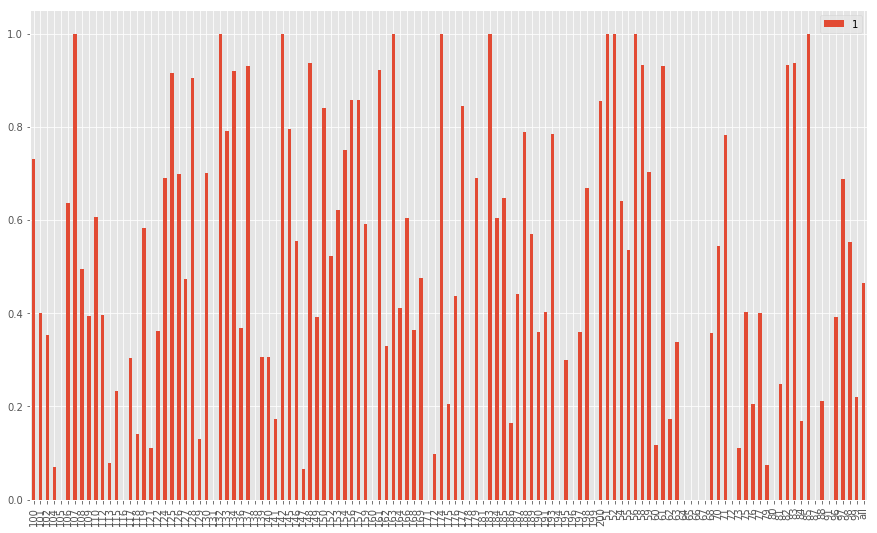

In [280]:
final_scoring = pd.DataFrame()

results = !trec_eval -m all_trec -q ./ap_88_89/qrel_test retrievals/ltr.run | grep -E "^ndcg_cut_10\s"

for result in results:
    result = re.sub( '\s+', ' ', result ).strip().split()

    idx = result[1]
    value = float(result[2])

    final_scoring.set_value(idx, 1, value)
    
final_scoring.plot(kind='bar', figsize=(15, 9))

In [302]:
evalData = pd.DataFrame()

for query in tokenized_queries:
    print(query)
    print(len(tfidf_rank[query]))    
    for document in tfidf_rank[query]:
        doc = index.document(int(query))[0]
        evalData = evalData.append({'query': query, 'doc': doc}, ignore_index=True)
    
evalData

111
1000
186
1000
56
1000
174
1000
104
1000
159
1000
171
1000
165
1000
103
1000
148
1000
52
1000
185
1000
127
1000
74
1000
60
1000
158
1000
113
1000
136
1000
194
1000
68
1000
65
1000
160
1000
72
1000
157
1000
144
1000
162
1000
170
1000
128
1000
133
1000
187
1000
183
1000
92
1000
154
1000
132
1000
101
1000
70
288
78
253
179
1000
184
1000
76
1000
59
1000
124
1000
98
1000
120
1000
91
1000
102
1000
138
1000
63
1000
140
1000
75
161
147
1000
150
1000
143
1000
137
1000
193
1000
166
1000
61
1000
58
1000
129
1000
79
1000
190
1000
164
1000
107
1000
85
1000
169
1000
192
1000
57
157
175
1000
195
1000
178
1000
167
1000
200
1000
155
1000
153
1000
139
1000
83
1000
95
1000
149
1000
105
1000
130
1000
67
1000
81
1000
172
1000
176
1000
51
1000
84
1000
96
1000
168
1000
119
1000
99
1000
134
1000
182
1000
142
1000
108
1000
123
1000
93
1000
173
1000
151
1000
116
1000
118
1000
146
1000
87
1000
117
1000
125
1000
180
1000
100
1000
112
1000
197
1000
189
1000
73
1000
109
1000
69
1000
121
1000
90
1000
156
1000
196

,doc,query
0,AP890425-0111,111
1,AP890425-0111,111
2,AP890425-0111,111
3,AP890425-0111,111
4,AP890425-0111,111
5,AP890425-0111,111
6,AP890425-0111,111
7,AP890425-0111,111
8,AP890425-0111,111
9,AP890425-0111,111


#### Get column values

In [305]:
## Query length
for idx, row in evalData.iterrows():
    
    score = len(tokenized_queries[str(evalData.iloc[idx]['query'])])
    evalData.at[idx, 'query length'] = score

In [307]:
## Dcoument length
for idx, row in evalData.iterrows():
    
    doc_id = extDocId2id[evalData.iloc[idx]['doc']]
    score = len(index.document(doc_id)[1])
    evalData.at[idx, 'document length'] = score

In [308]:
## Unique word in doc
for idx, row in evalData.iterrows():
    
    doc_id = extDocId2id[evalData.iloc[idx]['doc']]
    score = unique_terms_per_document[doc_id]
    evalData.at[idx, 'document unique'] = score

In [311]:
## Append TF-IDF data
for idx, row in evalData.iterrows():

    score = run_ltr_retrieval(tfidf, evalData.iloc[idx]['doc'], evalData.iloc[idx]['query'])
    evalData.at[idx, 'tfidf'] = score

In [312]:
## Append BM25 data
for idx, row in evalData.iterrows():

    score = run_ltr_retrieval(bm25, evalData.iloc[idx]['doc'], evalData.iloc[idx]['query'])
    evalData.at[idx, 'bm25'] = score

In [313]:
## Append Jelinek Mercer data
for idx, row in evalData.iterrows():

    score = run_ltr_retrieval(jelinek_mercer, evalData.iloc[idx]['doc'], evalData.iloc[idx]['query'])
    evalData.at[idx, 'jelinek mercer'] = score

In [314]:
## Append Dirichlet Prior data
for idx, row in evalData.iterrows():

    score = run_ltr_retrieval(dirichlet_prior, evalData.iloc[idx]['doc'], evalData.iloc[idx]['query'])
    evalData.at[idx, 'dirichlet prior'] = score

In [315]:
## Append Absolute Discounting data
for idx, row in evalData.iterrows():

    score = run_ltr_retrieval(absolute_discounting, evalData.iloc[idx]['doc'], evalData.iloc[idx]['query'])
    evalData.at[idx, 'absolute discounting'] = score

In [316]:
## Append Word2Vec Sum data
for idx, row in evalData.iterrows():

    score = run_ltr_retrieval(summed_vectors, evalData.iloc[idx]['doc'], evalData.iloc[idx]['query'])
    evalData.at[idx, 'w2v: sum'] = score

In [317]:
## Append Word2Vec Average data
for idx, row in evalData.iterrows():

    score = run_ltr_retrieval(averaged_vectors, evalData.iloc[idx]['doc'], evalData.iloc[idx]['query'])
    evalData.at[idx, 'w2v: avg'] = score

In [318]:
## Append Word2Vec WMD data
for idx, row in evalData.iterrows():

    score = run_ltr_retrieval(wmd_vectors, evalData.iloc[idx]['doc'], evalData.iloc[idx]['query'])
    evalData.at[idx, 'w2v: wmd'] = score

In [319]:
## Append LSI data
for idx, row in evalData.iterrows():    
        
    external_id = extDocId2id[str(evalData.iloc[idx]['doc'])]

    score = gensim_rank_pair(external_id, str(evalData.iloc[idx]['query']), lsi, transformed_queries)
    evalData.at[idx, 'lsi'] = score

In [320]:
## Append LDA data
for idx, row in evalData.iterrows():    
        
    external_id = extDocId2id[str(evalData.iloc[idx]['doc'])]

    score = gensim_rank_pair(external_id, str(evalData.iloc[idx]['query']), lda, transformed_queries)
    evalData.at[idx, 'lda'] = score

In [322]:
evalData

,doc,query,query length,document length,document unique,tfidf,bm25,jelinek mercer,dirichlet prior,absolute discounting,w2v: sum,w2v: avg,w2v: wmd,lsi,lda
0,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064326
1,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064338
2,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064320
3,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064300
4,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064304
5,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064323
6,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064334
7,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064323
8,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064318
9,AP890425-0111,111,2.0,568.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003639,0.064315


#### Store in CSV

In [323]:
evalData.to_csv('evalData.csv', encoding='utf-8')

In [ ]:
## Read existing data for quick updating
evalData = pd.read_csv('evalData.csv', delimiter=',')
evalData = trainData.drop(columns=['Unnamed: 0'])

In [324]:
def run_1000_retrieval(model_name, **args):

    run_out_path = '{}.run'.format(model_name)

    if os.path.exists(run_out_path):
        return

    retrieval_start_time = time.time()

    print('Retrieving using ltr')

    evalData = pd.read_csv('trainData.csv', delimiter=',')
    evalData = trainData.drop(columns=['Unnamed: 0'])

    data = {}

    # for qid in tokenized_queries: 

    for idx, row in evalData.iterrows():

        ext_doc = str(evalData.iloc[idx]['doc'])
        query = str(evalData.iloc[idx]['query'])

        inputDf = evalData[idx: idx + 1]
        inputDf = inputDf.drop(columns=['query', 'doc', 'result'])

        score = regression.predict_proba(inputDf)    

        if query in data:
            data[query].append((score[0][1], ext_doc))
        else:
            data[query] = []
            data[query].append((score[0][1], ext_doc))

    #     write out
    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,

            max_objects_per_query=1000)

In [325]:
start_time = time.time()

run_final_retrieval('retrievals/ltr1000')

print ('elapsed time:',time.time()-start_time)

Retrieving using ltr
elapsed time: 74.34756851196289


In [326]:
# trec_eval command for test of averaged vectors
!trec_eval -m all_trec ./ap_88_89/qrel retrievals/ltr1000.run | grep -E "^ndcg_cut_10\s|^map_cut_1000\s|^P_5\s|^recall_1000\s"

P_5                   	all	0.4800
recall_1000           	all	0.9883
ndcg_cut_10           	all	0.4660
map_cut_1000          	all	0.3994


### Task 4: Write a report [20 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
